In [1]:
!uv add -qU langgraph langchain langchain-openai

In [4]:
!uv add -q python-dotenv

In [5]:
from dotenv import load_dotenv

load_dotenv()

True

## Routing

### Model정의

In [6]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano")

### State 정의

In [8]:
from typing import TypedDict

class SupportState(TypedDict):
    query: str      # 고객 질문
    category: str   # 라우터가 분류한 카테고리
    response: str   # 전문가의 답변

In [9]:
from typing import Literal
from pydantic import BaseModel, Field

class RouteDecision(BaseModel):
    category: Literal['billing', 'technical', 'shipping', 'general'] = Field(description = '고객 문의 내용을 분석하여 적절한 부서를 선택하세요.')

In [10]:
router_llm = model.with_structured_output(RouteDecision)

### Node 정의

In [15]:
# [Manager] router 노드
def router_node(state: SupportState):
    query = state['query']
    print(f"\n--- [Router] 문의 분석 중: '{query}' ---")

    # LLM이 문맥을 읽고 카테고리를 결정함 (Rule-based가 아님!)
    decision = router_llm.invoke(query)

    print(f"  -> 분류 결과: {decision.category.upper()} 부서로 연결합니다.")
    return {"category": decision.category}

In [11]:
# [Expert A] 결제/환불 담당
def billing_expert(state: SupportState):
    print("--- [Billing Expert] 결제 전문가가 답변 작성 중 ---")
    prompt = f"당신은 결제 및 환불 전문가입니다. 다음 문의에 대해 정중하게 답변하세요: {state['query']}"
    msg = model.invoke(prompt)
    return {"response": msg.content}

# [Expert B] 기술 지원 담당
def technical_expert(state: SupportState):
    print("--- [Tech Expert] 기술 지원 엔지니어가 분석 중 ---")
    prompt = f"당신은 IT 엔지니어입니다. 다음 기술 문제에 대해 해결책을 제시하세요: {state['query']}"
    msg = model.invoke(prompt)
    return {"response": msg.content}

# [Expert C] 배송 담당
def shipping_expert(state: SupportState):
    print("--- [Shipping Expert] 물류 담당자가 배송 조회 중 ---")
    prompt = f"당신은 배송 관리자입니다. 다음 배송 문의에 대해 답변하세요: {state['query']}"
    msg = model.invoke(prompt)
    return {"response": msg.content}

# [Expert D] 일반 상담
def general_expert(state: SupportState):
    print("--- [General] 일반 상담원이 답변 중 ---")
    msg = model.invoke(f"다음 문의에 친절하게 답변하세요: {state['query']}")
    return {"response": msg.content}

### 그래프 생성

In [16]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(SupportState)

workflow.add_node("router_node", router_node)
workflow.add_node("billing_expert", billing_expert)
workflow.add_node("technical_expert", technical_expert)
workflow.add_node("shipping_expert", shipping_expert)
workflow.add_node("general_expert", general_expert)

workflow.add_edge(START, "router_node")

In [17]:
def route_to_expert(state: SupportState):
    category = state['category']

    if category == 'billing':
        return 'billing_expert'
    elif category == 'technical':
        return 'technical_expert'
    elif category == 'shipping':
        return 'shipping_expert'
    else :
        return 'general_expert'

In [18]:
workflow.add_conditional_edges(
    'router_node',
    route_to_expert,
    ['billing_expert', 'technical_expert', 'shipping_expert', 'general_expert']
)

In [19]:
workflow.add_edge('billing_expert', END)
workflow.add_edge('technical_expert', END)
workflow.add_edge('shipping_expert', END)
workflow.add_edge('general_expert', END)

In [20]:
app = workflow.compile()

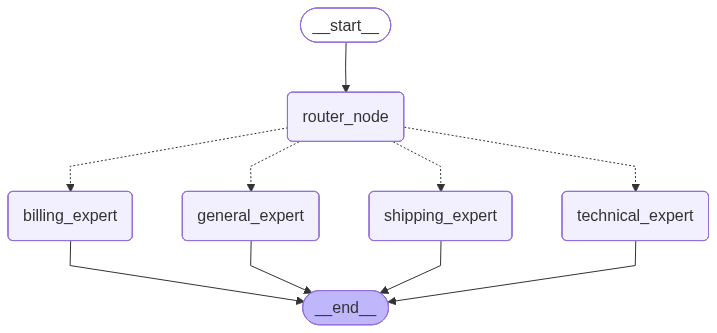

In [21]:
app

In [22]:
app.invoke({"query": "지난달 요금이 두 번 빠져나갔어요. 확인해주세요."})


--- [Router] 문의 분석 중: '지난달 요금이 두 번 빠져나갔어요. 확인해주세요.' ---


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouteDecision(category='billing'), input_type=RouteDecision])
  return self.__pydantic_serializer__.to_python(


  -> 분류 결과: BILLING 부서로 연결합니다.
--- [Billing Expert] 결제 전문가가 답변 작성 중 ---


{'query': '지난달 요금이 두 번 빠져나갔어요. 확인해주세요.',
 'category': 'billing',
 'response': '안녕하세요. 문의 주셔서 감사합니다. 지난달 요금이 두 번 빠져나간 현상으로 불편을 드려 죄송합니다. 저희가 신속하게 확인하고 조치하겠습니다.\n\n다음과 같이 확인 절차를 진행해 드리겠습니다.\n- 결제 기록 재검토: 귀하의 계정과 결제 내역에서 중복 청구 여부를 확인합니다.\n- 원인 파악: 구독 중복, 재청구, 이중 승인 등 가능성을 점검합니다.\n- 환불/크레딧 처리: 중복 청구로 확인되면 환불 또는 크레딧으로 조정하고, 카드사 정책에 따른 처리 기간을 안내드립니다.\n- 결과 안내: 확인 결과와 예상 처리 시간, 필요한 추가 조치를 안내드립니다.\n\n조사를 가장 빨리 시작하기 위해 아래 정보를 보내주시면 감사하겠습니다.\n- 계정에 연결된 이메일 주소\n- 지난달의 두 거래일(대략 가능)과 각 거래의 금액\n- 결제 수단의 끝 4자리\n- 거래 ID 또는 영수증 번호가 있다면 함께 공유\n- 가능하다면 두 거래의 영수증 사진/스크린샷\n\n제 정보를 받는 즉시 내부 시스템에서 확인 후, 중복 청구 여부를 판단해 결과와 처리 예상 시간을 신속히 알려드리겠습니다. 일반적으로 환불 처리 시간은 카드사 정책에 따라 3~10영업일 정도 소요될 수 있습니다. 상황에 따라 더 빨리 처리될 수 있습니다.\n\n다시 한 번 불편을 드려 죄송합니다. 최대한 신속하게 해결해 드리겠습니다. 감사합니다.'}

In [23]:
app.invoke({"query": "API 연결할 때 404 에러가 자꾸 떠요."})


--- [Router] 문의 분석 중: 'API 연결할 때 404 에러가 자꾸 떠요.' ---


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouteDecision(category='technical'), input_type=RouteDecision])
  return self.__pydantic_serializer__.to_python(


  -> 분류 결과: TECHNICAL 부서로 연결합니다.
--- [Tech Expert] 기술 지원 엔지니어가 분석 중 ---


{'query': 'API 연결할 때 404 에러가 자꾸 떠요.',
 'category': 'technical',
 'response': '다음과 같은 일반적인 원인들을 하나씩 점검해 보세요. 404는 보통 “해당 경로의 자원이 존재하지 않음”을 뜻하므로, 경로/호스트/환경 설정이 잘못되었거나 리소스가 없어서 나는 경우가 많습니다.\n\n1) 바로 확인해야 할 간단 체크리스트\n- 요청 URL이 정확한가요? 베이스 URL, API 버전(path), 엔드포인트 경로까지 대소문자, 슬래시 여부까지 확인.\n- 기본 경로 뒤에 필요한 경로 파라미터가 올바르게 전달되나요? 예) /v1/users/123 같은 경로의 123이 실제로 존재하는지 확인.\n- 요청 메서드가 엔드포인트에 맞나요? (GET/POST/PUT/DELETE 등)\n- 인증/권한 관련 헤더가 필요한가요? 토큰이 필요하면 누락되었거나 만료되진 않았나요? 일부 API는 보안을 위해 인증 실패를 404로 반환하기도 합니다.\n- 환경이 다르면 잘못된 베이스 URL을 사용하고 있진 않나요?(dev/prod/stage 등)\n- 프록시나 로드밸런서/CDN에서 잘못된 라우팅으로 404를 발생시키고 있나요?\n- 엔드포인트가 동적으로 생성되는 경우(리소스가 생성되지 않았거나 삭제된 경우) 해당 리소스가 실제로 존재하는지 확인.\n\n2) 문제를 재현하는 구체적 절차\n- curl로 기본적인 엔드포인트 호출해 보기:\n  - 예) curl -i -X GET "https://api.example.com/v1/users/123" -H "Authorization: Bearer <token>"\n  - 응답 헤더에 404인 경우, 경로 문제인지 확인하기 위해 같은 도메인에서 루트 엔드포인트를 조회해 봅니다: curl -I https://api.example.com/v1/\n- 엔드포인트의 문서와 실제 호출 URL이 일치하는지 대조\n- URL 인코딩 문제 확인: 경로 파라미터에 슬래시나 특수문자가 포함되면 인코딩이 필요할

In [24]:
app.invoke({"query": "주문한 노트북 언제 도착하나요?"})


--- [Router] 문의 분석 중: '주문한 노트북 언제 도착하나요?' ---


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=RouteDecision(category='shipping'), input_type=RouteDecision])
  return self.__pydantic_serializer__.to_python(


  -> 분류 결과: SHIPPING 부서로 연결합니다.
--- [Shipping Expert] 물류 담당자가 배송 조회 중 ---


{'query': '주문한 노트북 언제 도착하나요?',
 'category': 'shipping',
 'response': '다음과 같이 답변하시면 됩니다.\n\n1) 기본 응답(정보가 아직 부족할 때)\n- "고객님, 주문하신 노트북의 도착 예정일을 확인해 드리겠습니다. 정확한 ETA를 알려드리려면 주문번호가 필요합니다. 아래 정보를 보내주시면 즉시 조회해 최신 배송일과 트래킹 정보를 안내드리겠습니다.\n  - 주문번호\n  - 수령자 성함\n  - 배송지(도시/우편번호) 또는 트래킹번호"\n\n2) 이미 발송 상태인 경우의 예시 답변\n- "고객님께서 주신 정보로 배송 현황을 확인한 결과, 현재 운송 중이며 예상 도착일은 [YYYY-MM-DD]입니다. 트래킹 번호는 [TRACKING]이고 현재 상태는 [상태: 예, \'배송 중\', \'집하 대기\' 등]입니다. 배송 추적 링크: [Tracking URL]. 변동 사항이 생길 경우 즉시 다시 안내드리겠습니다. 감사합니다."\n\n3) 아직 발송 전인 경우의 예시 답변\n- "주문하신 노트북은 아직 발송 준비 중입니다. 일반적으로 결제 확인 후 영업일 기준 1-2일 내에 발송되며, 발송 시 ETA와 트래킹 정보를 함께 안내드립니다. 현재 상태는 [상태]입니다. 추가로 확인이 필요하시면 주문번호를 알려주시면 바로 조회해 드리겠습니다."\n\n필요 정보가 준비되면 바로 ETA를 확인해 드리겠습니다. 원하시면 지금 바로 주문번호를 보내 주세요.'}